In [37]:
# Imports
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('qt5agg')
import matplotlib.image as mpimg

import numpy as np
import matplotlib.pyplot as plt
from math import *
import cv2

import easygui
import scipy.io
from scipy.io import loadmat
from time import sleep

import os


#import those last always !
import params
from utils import *




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# Functions
def buildH(t_pre,s,t_post,r=0):
    H_pre_translation = np.array([[1, 0, t_pre[1]],
                                  [0, 1, t_pre[0]],
                                  [0, 0,    1]])
  
                          
    H_rotation = np.array([[cos(r),  -sin(r), 0],
                          [sin(r),   cos(r), 0],
                          [0,        0,      1]])
    
    H_scaling = np.array([[s[0], 0,   0],
                          [0,   s[1], 0],
                          [0,    0,   1]])
    
    H_post_translation = np.array([[1, 0, t_post[1]],
                                   [0, 1, t_post[0]],
                                   [0, 0, 1]])
    return H_post_translation@H_rotation@H_scaling@H_pre_translation


def transform_coordinates(coordinates, homography):
    coordinates = np.append(coordinates, np.array([1]))
    transformation = homography@coordinates.T
    transformation = transformation / transformation[2]
    transformed_coordinates = np.array(transformation[:2])
    return transformed_coordinates


def save_obj(filename, obj):
    with open(f'{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        
def load_obj(filename):
    with open(f'{filename}.pickle', 'rb') as handle:
        obj = pickle.load(handle)
        return obj

    
### GUI functions

    
def onclick(event):
    global size
    if size =="40x":
        dot_size = 1000
        font_size = 15

    elif size =="10x":
        dot_size = 100
        font_size = 10
        
    global output_hui
    global ix, iy
    ix, iy = event.xdata, event.ydata
    scattered.append(ax.scatter(ix,iy, s=dot_size, c='red'))
    plt.draw()
    global coords

    global indices

    xind = easygui.enterbox("electrode row:")
    yind = easygui.enterbox("electrode column:")
    try:
        indices.append([int(xind),int(yind)])
        coords.append([ix, iy])
        txt_scattered.append(ax.annotate(str(tuple(indices[-1])), (coords[-1][0]-35,coords[-1][1]+5), c='white', fontsize=font_size))
        
        plt.draw()
        print(f'electrode ({xind},{yind}): x = {ix}, y = {iy}')

    except TypeError:
        scattered[-1].set_visible(False)
        print(f" /!\ Point at {(ix,iy)} not added. Error on input format. Please enter only integers./!\ ")
        
    if len(coords) >= 5:

        np.save(os.path.join(output_gui,"indices_"+size), indices)
        np.save(os.path.join(output_gui,"coordinates_"+size), coords)
        output = easygui.msgbox(f"You have {len(coords)}/5 electrodes. Coordinates have been saved !", "Enough Points !",'ok')

        plt.close('all')
    return indices, coords


def onclose(event):
    global coords
    global indices
    global size
    global output_gui
    
    txt = 'Plot is closing. Do you want to save current points ? \n \n'
    for idx, ((xind, yind), (ix, iy)) in enumerate(zip(indices, coords)):
        txt += f'\t ({xind},{yind})\t: x = {ix},\t y = {iy} \n'
    output = easygui.ynbox(txt, "Saving on closing")
    if output:
        print(f"{len(coords)} electrodes saved :")
        np.save(os.path.join(output_gui,"indices_"+size), indices)
        np.save(os.path.join(output_gui,"coordinates_"+size), coords)
        
        [print(f'\t ({xind},{yind})\t: x = {ix},\t y = {iy}') for idx, ((xind, yind), (ix, iy)) in enumerate(zip(indices, coords))]
        
    else:
        print(f"{len(coords)} electrodes NOT saved on closing:")    

        
    fig.canvas.mpl_disconnect(cid)
    fig.canvas.mpl_disconnect(rmv)
    fig.canvas.mpl_disconnect(cls)
    

def onkey(event):
    global size
    global coords
    global indices
    global scattered
    global txt_scattered
    global output_gui
    
    if event.key == 'backspace':
        scattered[-1].set_visible(False)
        scattered.pop()
        
        txt_scattered[-1].set_visible(False)
        txt_scattered.pop()
        coords.pop()
        indices.pop()
        
        plt.draw()
        
    elif event.key in ['e', 'enter']:
        print(f"{len(coords)} electrodes saved :")
        np.save(os.path.join(output_gui,"indices_"+size), indices)
        np.save(os.path.join(output_gui,"coordinates_"+size), coords)
        
        [print(f'\t ({xind},{yind})\t: x = {ix},\t y = {iy}') for idx, ((xind, yind), (ix, iy)) in enumerate(zip(indices, coords))]
    
    elif event.key =='r':
        try:
            txt = 'Enter the point id to remove \n \n'
            for idx, ((xind, yind), (ix, iy)) in enumerate(zip(indices, coords)):
                txt += f'{idx}\t --> \t ({xind},{yind})\t\n'
            idx = int(easygui.enterbox(txt))
            scattered[idx].set_visible(False)
            scattered.pop(idx)

            txt_scattered[idx].set_visible(False)
            txt_scattered.pop(idx)
            coords.pop(idx)
            indices.pop(idx)

            plt.draw()
        except:
            print("Wrong input")
            pass
    
    elif event.key == 'escape':
        plt.close(fig)
    else:
        print(event.key)


# Registration in RIG MEA3

This notebook is made to transform images and coordinates in a commom referential in the MEA3 RIG.

There are different referentials, with different origins, axis orientation, units.
- the checkerboard [checks]
- the Digital Micromirror Device (DMD) [px dmd]
- the picture taken with the 10X objective [px camera 10X]
- the picture taken with the 40X objective [px camera 40X]
- the picture taken with the 40X objective and epifluorescence settings [px camera 40X epi settings]
- the multi electrode array (MEA) [µm]

We use homographies to make the transformations.
The goal of this notebook is to provide the homographies necessary to transform images/point coordiantes from any of these referentials into any other.
This can be use for illustation figures, where images of the electrodes and stimulus are overlaid, or to compute the distance between receptive field center and digital holography spots.
The output of the notebook is a dictionnary containing all the homographies.

The notebook comes in different sections. In each of them an homography is computed, and a sanity check is plotted.
In the end, additional sanity checks are plotted.

- Section 1: Get the homography to transform from checkerboard to dmd
- Section 2: Get the homography to transform from dmd to camera 10x
- Section 3: Get the homography to transform from camera 10x to MEA
- Section 4: Get the homography to transform from camera 40x to MEA
- Section 5: Get the homography to transform from camera 40x (epifluorescence) to camera 40x (MEA)
- Section 6: Compute all homographies and useful transformed images/coordinates
- Section 7: Additional sanity checks and visualisations
- Section 8: Work in progress (remains to be done for improving the procedure)


Abbreviations used

- DMD = Digital Micromirror Device
- MEA = Multi Electrode Array
- DH = Digital Holography

In [17]:
output_gui = os.path.join(Analysis_directory,"output_gui")
if not os.path.exists(output_gui):os.mkdir(output_gui)

# Loading all files

In [3]:
"""
    Parameters
"""
# Main directory containing notebook specific directory where plots will be saved
output_directory = params.output_directory

# the sapcing between two electrodes of the MEA in µm
mea_spacing = params.mea_spacing                    

# number of electrodes on one side of the MEA
n_electrodes = params.n_electrodes             

#DH gui folder containing frames
registration_frames = params.registration_frames

# List of all frames available in the registration frame folder
frames_names = os.listdir(registration_frames) 

#DH gui folder containing fluorescent images
registration_imgs = params.registration_imgs

#List of all images available in the registration images folder
images_names = os.listdir(registration_imgs)

#loading setup params
size_dmd = params.size_dmd
pxl_size_dmd = params.pxl_size_dmd

#Read params file for used mea
mea_spacing = params.mea_spacing


"""
    Input
"""
                        #################################
                        ########## MODIFY HERE ##########
                        #################################
            
mea_10x_path = os.path.join(params.root,"pictures/mea_10X.jpg")

mea_40x_path = os.path.join(params.root,"pictures/mea_40X.jpg")



print("All frames : ")
print(*['{} : {}'.format(i,frame_file) for i, frame_file in enumerate(frames_names)], sep="\n")
sleep(0.1)
frames_path = frames_names[int(input("\nSelect frames file for spots: "))]
print(f"\nSelected files : {frames_path} \n")

print("All fluorescent images : ")
print(*['{} : {}'.format(i,img_file) for i, img_file in enumerate(images_names)], sep="\n")
sleep(0.1)
epi_image = images_names[int(input("\nSelect image : "))]
epifluorescence_40x_path = os.path.normpath(os.path.join(registration_imgs, epi_image))
print(f"Image loaded : {epifluorescence_40x_path} \n")

n_pixels_square = int(input("Number of pixels per square in the checkerboard : "))

#Nb of checks used on the checkerboard
nb_checks_x = int(input("Select number of checks (usually 40 for fine checkerboard) : "))   ##### Here change the number of checks if necessary
number_of_check = [nb_checks_x, nb_checks_x]
print(f"Checkerboard {nb_checks_x}x{nb_checks_x} with {n_pixels_square*nb_checks_x*nb_checks_x} pixels")

"""
    Processing
"""


Analysis_directory = os.path.join(output_directory, f"{epi_image.split('.')[0]}_registration")
if not os.path.exists(Analysis_directory): os.mkdir(Analysis_directory)
    
homographies_directory = os.path.join(Analysis_directory, "homographies")
if not os.path.exists(homographies_directory): os.mkdir(homographies_directory)

sanity_check_directory = os.path.join(Analysis_directory, "sanity_checks")
if not os.path.exists(sanity_check_directory):os.mkdir(sanity_check_directory)

output_gui = os.path.join(Analysis_directory,"output_gui")
if not os.path.exists(output_gui):os.mkdir(output_gui)

mea_10x_picture = cv2.imread(mea_10x_path)
mea_40x_picture = cv2.imread(mea_40x_path)
epifluorescence_40x_picture = cv2.imread(epifluorescence_40x_path)
frames = loadmat(os.path.join(registration_frames, frames_path))
point_coordinates_40X_px = frames["PatternImage"]

size_picture_10X = mea_10x_picture.shape[:2]
size_picture_40X = mea_40x_picture.shape[:2]
size_picture_epi = epifluorescence_40x_picture.shape[:2]


# Take the two cases when microscope camera image has been binned or not
if size_picture_10X == (1024,1344):
    pxl_size_picture_10X = 1.28
elif size_picture_10X == (512,672):
    pxl_size_picture_10X = 1.28*2

if size_picture_40X == (1024,1344):
    pxl_size_picture_40X = 1.28
elif size_picture_40X == (512,672):
    pxl_size_picture_40X = 1.28*2

if size_picture_epi == (1024,1344):
    pxl_size_picture_epi = 1.28
elif size_picture_epi == (512,672):
    pxl_size_picture_epi = 1.28*2


print('--- Cell Done ---')

All frames : 
0 : DH_frames_20231125_21_01_23.mat
1 : DH_frames_20231125_16_34_36.mat
2 : DH_frames.mat
3 : DH_frames_20211210_17_11_20.mat

Select frames file for spots: 3

Selected files : DH_frames_20211210_17_11_20.mat 

All fluorescent images : 
0 : start_(-37).jpg
1 : epifluorescence_40X.jpg
2 : MEA_00X.jpg
3 : HoloStim2.JPG
4 : Retina_40X_(-25).jpg
5 : MEA_10X.jpg
6 : Retina_40X_(-30).jpg

Select image : 1
Image loaded : /home/guiglaz/Documents/Pipeline_Dev/20231125_VIP.Project_FF+Disk_100um_DHguiOptimization/imgs/epifluorescence_40X.jpg 

Number of pixels per square in the checkerboard : 20
Select number of checks (usually 40 for fine checkerboard) : 40
Checkerboard 40x40 with 32000 pixels
--- Cell Done ---


# SECTION 1: compute all homographies and plots sanity checks

# checkerboard to dmd homography


# Section 1: Get the homography to transform from checkerboard to dmd

This homography is completely determined by the parameters provided : 
- number_of_check
- n_pixels_square
- size_dmd

## Compute the homography and save it

In [4]:
# Compute and save homography
H_checker2DMD = buildH(t_pre  = -np.array(number_of_check)/2,
                       s      = np.array((n_pixels_square, n_pixels_square)),
                       t_post = np.array(size_dmd)/2 )
np.save(os.path.join(homographies_directory,"h_checkerboard_to_dmd"),H_checker2DMD)

## Sanity check.
Visualize a mock checkerboard frame overlaid on the dmd area. 

The checkerboard frame should be centered!

If not, check if the paramaeters you provided are correct: number_of_check, n_pixels_square, size_dmd

In [5]:
# Plot and save sanity check

# mock checkerboard frame
checkerboard_frame = np.random.choice([0,1], size=(number_of_check[0],number_of_check[1])).astype(np.uint8)

# mock dmd space
dmd = 0.5 * np.ones((size_dmd[0],size_dmd[1]))

# get homography checkerboard to dmd
H_checker2DMD = np.load(os.path.join(homographies_directory,"h_checkerboard_to_dmd.npy"))

# Warp source image to destination based on homography

im_out = cv2.warpPerspective(checkerboard_frame, H_checker2DMD, (dmd.shape[1],dmd.shape[0]), flags=cv2.INTER_NEAREST)

fig, axs = plt.subplots(ncols=2, figsize=(10,5))

ax = axs[0]
ax.imshow(checkerboard_frame, cmap='gray')
ax.set_title("checkerboard")
ax.set_xlabel("check")
ax.set_ylabel("check")


ax = axs[1]
ax.imshow(dmd,cmap='gray')
ax.imshow(im_out, cmap='gray')
ax.set_title("checkerboard in dmd referential")
ax.set_xlabel("px")
ax.set_ylabel("px")

plt.show(block=False)
plt.savefig(os.path.join(sanity_check_directory, "checkerboard_dmd_registration"))

# Section 2: Get the homography to transform from DMD to camera 10X

This homography is completely determined by the parameters provided : 
- pxl_size_picture_10X
- size_picture_10X
- pxl_size_dmd
- size_dmd

## Compute the homography and save it

In [6]:
# Compute and save homography
H_dmd2Camera  = buildH(t_pre  = -np.array(size_dmd)/2,
                       s      = np.array((pxl_size_dmd/pxl_size_picture_10X, pxl_size_dmd/pxl_size_picture_10X)),
                       r      = pi/2,
                       t_post = np.array(size_picture_10X)/2 )
np.save(os.path.join(homographies_directory,"h_dmd_to_camera_10X"),H_dmd2Camera)

## Sanity check

Visualize a mock DMD frame overlaid on the picture (10x objective), and the opposite

In [11]:
# Sanity check. Plot the area of the DMD, and a 10x picture on top of it

dmd = np.ones((size_dmd[0],size_dmd[1]))

im_out = cv2.warpPerspective(mea_10x_picture, np.linalg.inv(H_dmd2Camera), (dmd.shape[1],dmd.shape[0]), flags=cv2.INTER_NEAREST)


fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(dmd, cmap='gray')
ax.imshow(im_out, cmap='gray', alpha=.5)
ax.set_title("camera 10x picture on the area of the projected DMD image")
ax.set_xlabel("px")
ax.set_ylabel("px")

plt.show(block=False)
plt.savefig(os.path.join(sanity_check_directory, "dmd_camera_registration"))


# Section 3: Get the homography to transform from camera 10X to MEA

For this one, you need to use a Graphical User Interface to indicate the position of 4 electrodes.
A window pops up, you have to click on 5 electrodes and gives their coordiantes. 

## Use GUI to get coordinates and save them

In [40]:
# Get the indices and coordinates of electrodes in 10X picture (GUI)

size ="10x"
# output_gui = os.path.join(Analysis_directory,"output_gui")

plot = False
try:
    indices = list(np.load(os.path.join(output_gui,"indices_10x.npy")))
    coords  = list(np.load(os.path.join(output_gui,"coordinates_10x.npy")))
    
    while True:
        if len(coords)<5:
            print("\nYou need 5 electrodes for the registration to work fine. \nStarting GUI ...\n")
            plot = True
            break
            
        print("Current electrodes listed:")
        [print(f'\t Electrode {idx} -> N° ({xind},{yind})\t: x = {ix},\t y = {iy}') for idx, ((xind, yind), (ix, iy)) in enumerate(zip(indices, coords))]

        rep = input("Enter the number of a point to remove it, 'all' to remove all points, 'edit' to see the gui, 'ENTER' to continue: ")

        if rep in ['all', 'All']:
            print('All electrodes are removed')
            indices = []
            coords = []
            break
        elif rep.isdigit() and 0 <= int(rep) < len(coords):
            idx = int(rep)
            print(f'Electrode {indices.pop(idx)}\t: x = {coords[idx][0]},\t y = {coords[idx][1]} removed...')
            coords.pop(idx)
        elif rep == 'edit':
            plot = True
            break
        elif rep == '':
            np.save(os.path.join(output_gui,"indices_10x.npy"), indices)
            np.save(os.path.join(output_gui,"coordinates_10x.npy"), coords)
            break
        else:
            print("Input could not be interpreted...\n")
    
except:
    print("Starting new electrodes list")
    coords = []
    indices = []
    plot=True
    
if plot or len(coords)<5:
    
    image = mea_10x_picture

    fig, ax = plt.subplots(figsize=(20,30))

    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    rmv = fig.canvas.mpl_connect('key_press_event', onkey)
    cls = fig.canvas.mpl_connect('close_event', onclose)

    imgplot = plt.imshow(image)
    X = [x for (x,y) in coords]
    Y = [y for (x,y) in coords]
    scattered     = [ax.scatter(x,y, s=100, c='red') for (x,y) in coords]
    txt_scattered = [plt.annotate(str(tuple(indices[idx])), (X[idx]-35,Y[idx]+5), c='white', fontsize=10) for idx in range(len(indices))]
    
    textstr="""---- List of keys ----\n
    E or Enter  : Save points\n
    R               : Remove a point\n
    Backspace : Remove last point\n
    ESC           : Close\n
    Click          : Add a point"""    
    props = dict(boxstyle='round', facecolor='grey', alpha=0.5)
    plt.text(1.01, 0.98,textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
    plt.tight_layout()
    plt.show()
    
    ## Plotting the reference image 
    
    im10x_path = os.path.join(params.ressources,"MEA_10X.jpg")

    im10x = cv2.imread(im10x_path)

    lines10X = np.arange(505, 850, 22.3)
    Hlines10X = np.arange(347, 700, 22.3)

    fig1 = plt.figure(figsize=(10,10))
    fig1.suptitle("10X MEA Electrodes Numbers Reference")
    plt.imshow(im10x)

    for idx, line in enumerate(lines10X):
        if idx % 3 != 0:
            continue
        plt.axvline(line, alpha=0.4, linestyle='--', c='red')
        plt.text(line-8, -10, str(idx), color='black', rotation=0)

    for idx, line in enumerate(Hlines10X):
        if idx % 3 != 0:
            continue
        plt.axhline(line, alpha=0.4, linestyle='--', c='red')
        plt.text(-48, line+5, str(idx), color='black', rotation=0)
    plt.axis('off')
    plt.show(block=True)


Current electrodes listed:
	 Electrode 0 -> N° (1,15)	: x = 857.8583831332523,	 y = 366.44435756215853
	 Electrode 1 -> N° (8,15)	: x = 860.9529035052597,	 y = 525.8121567205336
	 Electrode 2 -> N° (0,1)	: x = 542.9909352815113,	 y = 354.8399061671313
	 Electrode 3 -> N° (7,7)	: x = 682.2443520218391,	 y = 508.7922946744935
	 Electrode 4 -> N° (14,0)	: x = 528.2919635144767,	 y = 670.480984111874
Enter the number of a point to remove it, 'all' to remove all points, 'edit' to see the gui, 'ENTER' to continue: 4
Electrode [14  0]	: x = 528.2919635144767,	 y = 670.480984111874 removed...

 You need 5 electrodes for the registration to work fine. 
Starting GUI ...

electrode (15,1): x = 553.048126490535, y = 691.3689966229233
5 electrodes saved :
	 (1,15)	: x = 857.8583831332523,	 y = 366.44435756215853
	 (8,15)	: x = 860.9529035052597,	 y = 525.8121567205336
	 (0,1)	: x = 542.9909352815113,	 y = 354.8399061671313
	 (7,7)	: x = 682.2443520218391,	 y = 508.7922946744935
	 (15,1)	: x = 553.0

In [47]:
np.save(os.path.join(output_gui,"indices_10X"), indices)
np.save(os.path.join(output_gui,"coordinates_10X"), coords)

## Compute the homography

In [52]:
# Get the camera 10X to mea homography
indices = np.load(os.path.join(output_gui,"indices_10X.npy"))
coordinates = np.load(os.path.join(output_gui,"coordinates_10X.npy"))

indices = np.array([[i[0]*mea_spacing,i[1]*mea_spacing] for i in indices])

h_camera_10x_to_mea, status = cv2.findHomography(coordinates, indices)

np.save(os.path.join(homographies_directory,"h_camera_10x_to_mea"),h_camera_10x_to_mea)

## Sanity check

In [54]:
# Transform the 10X picture in the MEA referential, then plot the image and the electrodes in this referential.
h_camera_10X_to_mea = np.load(os.path.join(homographies_directory,"h_camera_10x_to_mea.npy"))

picture_transformed = cv2.warpPerspective(mea_10x_picture, h_camera_10x_to_mea, (16*30,16*30), flags=cv2.INTER_NEAREST)

fig, axs = plt.subplots(ncols=2)

# MEA referential
ax = axs[0]
ax.set_xlabel("µm")
ax.set_ylabel("µm")
ax.set_title("Picture 10x in MEA referential")
ax.imshow(picture_transformed, origin='lower')
for j in range(16):
    for i in range(16):
        coordinates = [i*30,j*30]
        ax.scatter(coordinates[0],coordinates[1], marker='+', color='g', alpha=.5)

# Picture referential
ax = axs[1]
ax.set_xlabel("Pixel camera 10x")
ax.set_ylabel("Pixel camera 10x")
ax.set_title("MEA electrodes overlaid on picture 10x")

ax.imshow(mea_10x_picture, origin='lower')

h_inv = np.linalg.inv(h_camera_10X_to_mea)
for i in range(16):
    for j in range(16):
        coordinates = [i*30,j*30]
        transformed_coordinates = transform_coordinates(coordinates,h_inv)
        ax.scatter(transformed_coordinates[0],transformed_coordinates[1], marker='+', color='g', alpha=.3)

plt.tight_layout()

plt.savefig(os.path.join(sanity_check_directory,"camera_10x_to_mea"))

# Section 4: Get the homography to transform from camera 40X to MEA

For this one, you need to use a Graphical User Interface to indicate the position of 4 electrodes.
A window pops up, you have to click on 4 electrodes and gives their coordiantes. # camera 40x to mea homography

## Use GUI to get coordinates and save them

In [63]:
# Get the indices and coordinates of electrodes in 40X picture (GUI)
size ="40x"
plot = False

try:
    indices = list(np.load(os.path.join(output_gui,"indices_40x.npy")))
    coords  = list(np.load(os.path.join(output_gui,"coordinates_40x.npy")))
    
    while True:
        if len(coords)<5:
            print("\nYou need 5 electrodes for the registration to work fine. \nStarting GUI ...\n")
            plot = True
            break
            
        print("Current electrodes listed:")
        [print(f'\t Electrode {idx} -> N° ({xind},{yind})\t: x = {ix},\t y = {iy}') for idx, ((xind, yind), (ix, iy)) in enumerate(zip(indices, coords))]

        rep = input("Enter the number of a point to remove it, 'all' to remove all points, 'edit' to see the gui, 'ENTER' to continue: ")

        if rep in ['all', 'All']:
            print('All electrodes are removed')
            indices = []
            coords = []
            break
        elif rep.isdigit() and 0 <= int(rep) < len(coords):
            idx = int(rep)
            print(f'Electrode {indices.pop(idx)}\t: x = {coords[idx][0]},\t y = {coords[idx][1]} removed...')
            coords.pop(idx)
        elif rep == 'edit':
            plot = True
            break
        elif rep == '':
            np.save(os.path.join(output_gui,"indices_40x.npy"), indices)
            np.save(os.path.join(output_gui,"coordinates_40x.npy"), coords)
            break
        else:
            print("Input could not be interpreted...\n")
    
except:
    print("Starting new electrodes list")
    coords = []
    indices = []
    plot=True
    
if plot or len(coords)<5:
    
    image = mea_40x_picture

    fig, ax = plt.subplots(figsize=(20,30))
    fig 
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    rmv = fig.canvas.mpl_connect('key_press_event', onkey)
    cls = fig.canvas.mpl_connect('close_event', onclose)

    imgplot = plt.imshow(image)
    X = [x for (x,y) in coords]
    Y = [y for (x,y) in coords]
    scattered     = [ax.scatter(x,y, s=1000, c='red') for (x,y) in coords]
    txt_scattered = [plt.annotate(str(tuple(indices[idx])), (X[idx]-35,Y[idx]+5), c='white', fontsize=20) for idx in range(len(indices))]
    textstr="""---- List of keys ----\n
    E or Enter  : Save points\n
    R               : Remove a point\n
    Backspace : Remove last point\n
    ESC           : Close\n
    Click          : Add a point"""
    
    
    props = dict(boxstyle='round', facecolor='grey', alpha=0.5)
    plt.text(1.01, 0.98,textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
    plt.tight_layout()
    plt.show()
    
        ##Plotting the reference image
    
    im40x_path = os.path.join(params.ressources,"MEA_40X.jpg")

    im40x = cv2.imread(im40x_path)

    lines40X = np.arange(56, 1320, 89)
    Hlines40X = np.arange(8, 1000, 90)

    fig2 = plt.figure(figsize=(10,10))
    fig2.suptitle("40X MEA Electrodes Numbers Reference")
    plt.imshow(im40x)

    for idx, line in enumerate(lines40X):
        if idx % 2 == 0:
            continue
        plt.axvline(line, alpha=0.5, linestyle='--', c='red')
        plt.text(line-18, -20, str(idx), color='black', rotation=0)

    for idx, line in enumerate(Hlines40X):
        if idx % 2 == 0:
            continue
        plt.axhline(line, alpha=0.5, linestyle='--', c='red')
        plt.text(-50, line+5, str(idx), color='black', rotation=0)
    plt.axis('off')
    plt.show(block=True)


Current electrodes listed:
	 Electrode 0 -> N° (7,7)	: x = 671.4135307198135,	 y = 484.03613169843527
	 Electrode 1 -> N° (8,8)	: x = 767.3436622520393,	 y = 567.588181742632
	 Electrode 2 -> N° (2,2)	: x = 211.10362538373008,	 y = 48.48238933841026
	 Electrode 3 -> N° (9,2)	: x = 231.21800780177742,	 y = 676.6700248558886
	 Electrode 4 -> N° (10,13)	: x = 1214.5018560070916,	 y = 731.5977614590179
Enter the number of a point to remove it, 'all' to remove all points, 'edit' to see the gui, 'ENTER' to continue: 1
Electrode [8 8]	: x = 767.3436622520393,	 y = 567.588181742632 removed...

You need 5 electrodes for the registration to work fine. 
Starting GUI ...

electrode (11,11): x = 1040.435085081682, y = 829.0751531772473
electrode (7,8): x = 763.4755117870302, y = 478.62072104742253
electrode (6,9): x = 850.1220822032342, y = 389.6532603522131
5 electrodes saved :
	 (2,2)	: x = 211.10362538373008,	 y = 48.48238933841026
	 (9,2)	: x = 231.21800780177742,	 y = 676.6700248558886
	 (11,1

In [56]:
np.save(os.path.join(output_gui,"indices_40x"), indices)
np.save(os.path.join(output_gui,"coordinates_40x"), coords)

## Compute the homography

In [57]:
# Get the camera 10X to mea homography
indices = np.load(os.path.join(output_gui,"indices_40x.npy"))
coordinates = np.load(os.path.join(output_gui,"coordinates_40x.npy"))

indices = np.array([[i[0]*mea_spacing,i[1]*mea_spacing] for i in indices])

h_camera_40x_to_mea, status = cv2.findHomography(coordinates, indices)

np.save(os.path.join(homographies_directory,"h_camera_40x_to_mea"),h_camera_40x_to_mea)

## Sanity check


In [58]:
# Transform the 10X picture in the MEA referential, then plot the image and the electrodes in this referential.
h_camera_40x_to_mea = np.load(os.path.join(homographies_directory,"h_camera_40x_to_mea.npy"))

picture_transformed = cv2.warpPerspective(mea_40x_picture, h_camera_40x_to_mea, (16*30,16*30), flags=cv2.INTER_NEAREST)

fig, axs = plt.subplots(ncols=2)

# MEA referential
ax = axs[0]
ax.set_xlabel("µm")
ax.set_ylabel("µm")
ax.set_title("Picture 40x in MEA referential")

ax.imshow(picture_transformed, origin='lower')
for j in range(16):
    for i in range(16):
        coordinates = [i*30,j*30]
        ax.scatter(coordinates[0],coordinates[1], marker='+', color='g', alpha=.5)

# Picture referential
ax = axs[1]
ax.set_xlabel("Pixel camera 40x")
ax.set_ylabel("Pixel camera 40x")
ax.set_title("MEA electrodes overlaid on picture 40x")

ax.imshow(mea_40x_picture, origin='lower')

h_inv = np.linalg.inv(h_camera_40x_to_mea)
for i in range(16):
    for j in range(16):
        coordinates = [i*30,j*30]
        transformed_coordinates = transform_coordinates(coordinates,h_inv)
        ax.scatter(transformed_coordinates[0],transformed_coordinates[1], marker='+', color='g', alpha=.3)

plt.tight_layout()

plt.savefig(os.path.join(sanity_check_directory,"camera_40x_to_mea"))

# Section 5: Get the homography to transform from camera 40x (epifluorescence) to camera 40x (MEA)
This homograpy is completely defined by the parameters you provided

## Compute the homography

In [38]:
ratio = int(size_picture_40X[0]/size_picture_epi[0])

H_epifluo_to_40X = buildH(t_pre  = np.array([0,0]),
                       s      = np.array((ratio, ratio)),
                       t_post = np.array([0,0]) )

np.save(os.path.join(homographies_directory,"h_epifluo_to_40X"),H_epifluo_to_40X)

## Sanity check

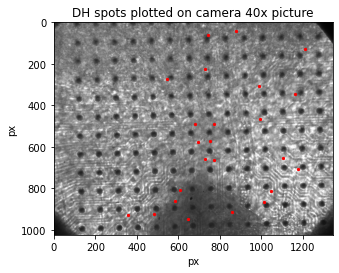

In [42]:
# Plot the DH spots on top of 40X epifluorescence image



fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(mea_40x_picture, cmap='gray')

for i in point_coordinates_40X_px:
    transformed_coordinates = transform_coordinates(i,H_epifluo_to_40X)

    ax.scatter(transformed_coordinates[0], transformed_coordinates[1], color='r', marker='o', s=5)
    
ax.set_title("DH spots plotted on camera 40x picture")
ax.set_xlabel("px")
ax.set_ylabel("px")

plt.savefig(os.path.join(sanity_check_directory, "epi_camera_40x_registration"))

# Section 6: compute all homographies and useful transformed images/coordinates

the referentials are
- checkerboard
- dmd
- camera_10X
- camera_40X
- epifluo_40X
- mea

outputs a dictionnary containing all possible homographies between these referentiels, allowing to make any transformations and plots

In [53]:
referentials = ["checkerboard",
               "dmd",
               "camera10x",
               "camera40x",
               "epi40x",
               "mea"]

h_camera_10X_to_mea = np.load(os.path.join(homographies_directory,"h_camera_10X_to_mea.npy"))
h_camera_40X_to_mea = np.load(os.path.join(homographies_directory,"h_camera_40X_to_mea.npy"))
h_checkerboard_to_dmd = np.load(os.path.join(homographies_directory,"h_checkerboard_to_dmd.npy"))
h_dmd_to_camera_10X = np.load(os.path.join(homographies_directory,"h_dmd_to_camera_10X.npy"))
h_epifluo_to_40X = np.load(os.path.join(homographies_directory,"h_epifluo_to_40X.npy"))

homographies = {}

for ref in referentials:
    homographies[ref] = {}
    
for ref in referentials:
    homographies[ref][ref] = np.identity(3)
    
    
# Homography A -> B = C -> B @ A -> C
    
homographies["checkerboard"]["dmd"] = h_checkerboard_to_dmd
homographies["dmd"]["camera10x"] = h_dmd_to_camera_10X
homographies["camera10x"]["mea"] = h_camera_10X_to_mea
homographies["camera40x"]["mea"] = h_camera_40X_to_mea
homographies["epi40x"]["camera40x"] = h_epifluo_to_40X

homographies["mea"]["camera10x"] = np.linalg.inv(homographies["camera10x"]["mea"])
homographies["mea"]["camera40x"] = np.linalg.inv(homographies["camera40x"]["mea"])
homographies["dmd"]["checkerboard"] = np.linalg.inv(homographies["checkerboard"]["dmd"])
homographies["camera10x"]["dmd"] = np.linalg.inv(homographies["dmd"]["camera10x"])
homographies["camera40x"]["epi40x"] = np.linalg.inv(homographies["epi40x"]["camera40x"])



homographies["checkerboard"]["camera10x"] = homographies["dmd"]["camera10x"] @ homographies["checkerboard"]["dmd"]
homographies["camera10x"]["checkerboard"] = np.linalg.inv(homographies["checkerboard"]["camera10x"])


homographies["checkerboard"]["mea"] = homographies["camera10x"]["mea"] @ homographies["checkerboard"]["camera10x"]
homographies["mea"]["checkerboard"] = np.linalg.inv(homographies["checkerboard"]["mea"])

homographies["dmd"]["mea"] = homographies["camera10x"]["mea"] @ homographies["dmd"]["camera10x"]
homographies["mea"]["dmd"] = np.linalg.inv(homographies["dmd"]["mea"])


homographies["camera10x"]["camera40x"] = homographies["mea"]["camera40x"] @ homographies["camera10x"]["mea"]
homographies["camera40x"]["camera10x"] = np.linalg.inv(homographies["camera10x"]["camera40x"])


homographies["camera10x"]["epi40x"] = homographies["camera40x"]["epi40x"] @ homographies["camera10x"]["camera40x"]
homographies["epi40x"]["camera10x"] = np.linalg.inv(homographies["camera10x"]["epi40x"])

homographies["checkerboard"]["camera40x"] = homographies["camera10x"]["camera40x"]@homographies["checkerboard"]["camera10x"]
homographies["camera40x"]["checkerboard"] = np.linalg.inv(homographies["checkerboard"]["camera40x"])

homographies["checkerboard"]["epi40x"] = homographies["camera40x"]["epi40x"] @ homographies["checkerboard"]["camera40x"]
homographies["epi40x"]["checkerboard"] = np.linalg.inv(homographies["checkerboard"]["epi40x"])

homographies["dmd"]["camera40x"] = homographies["camera10x"]["camera40x"] @ homographies["dmd"]["camera10x"]
homographies["camera40x"]["dmd"] = np.linalg.inv(homographies["dmd"]["camera40x"])

homographies["dmd"]["epi40x"] = homographies["camera40x"]["epi40x"] @ homographies["dmd"]["camera40x"]
homographies["epi40x"]["dmd"] = np.linalg.inv(homographies["dmd"]["epi40x"])

homographies["epi40x"]["mea"] = homographies["camera40x"]["mea"] @ homographies["epi40x"]["camera40x"]
homographies["mea"]["epi40x"] = np.linalg.inv(homographies["epi40x"]["mea"])


save_obj(homographies,os.path.join(homographies_directory,"all_homographies"))

# Other sanity checks

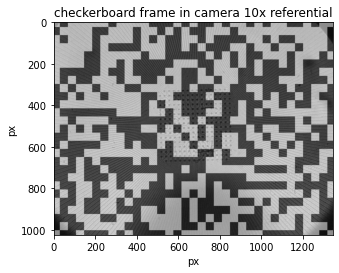

In [44]:
# Sanity check. Plot the checkerboard in the camera 10X referential

checkerboard_frame = np.random.choice([0,1], size=(number_of_check[0],number_of_check[1])).astype(np.uint8)

im_out = cv2.warpPerspective(checkerboard_frame, H_dmd2Camera@H_checker2DMD, (mea_10x_picture.shape[1],mea_10x_picture.shape[0]), flags=cv2.INTER_NEAREST)


fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(mea_10x_picture, cmap='gray')
ax.imshow(im_out, cmap='gray', alpha=.5)

ax.set_title("checkerboard frame in camera 10x referential")
ax.set_xlabel("px")
ax.set_ylabel("px")

plt.savefig(os.path.join(sanity_check_directory, "checkerboard_camera_10x_registration"))

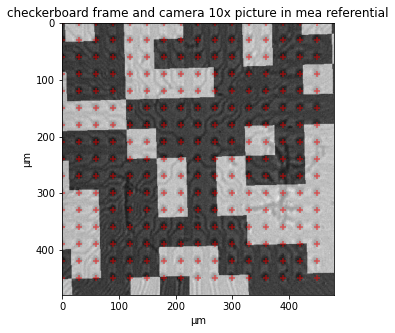

In [45]:
# Sanity check. Plot the checkerboard and the picture in the camera 10X referential, with the electrodes ploted
checkerboard_frame = np.random.choice([0,1], size=(number_of_check[0],number_of_check[1])).astype(np.uint8)

t_checker = cv2.warpPerspective(checkerboard_frame, h_camera_10X_to_mea@H_dmd2Camera@H_checker2DMD, (16*30,16*30), flags=cv2.INTER_NEAREST)
t_picture = cv2.warpPerspective(mea_10x_picture, h_camera_10X_to_mea, (16*30,16*30), flags=cv2.INTER_NEAREST)


fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(t_picture, cmap='gray')

ax.imshow(t_checker, cmap='gray', alpha=.5)
for j in range(16):
    for i in range(16):
        coordinates = [i*30,j*30]
        ax.scatter(coordinates[0],coordinates[1], marker='+', color='r', alpha=.5)
        
ax.set_title("checkerboard frame and camera 10x picture in mea referential")
ax.set_xlabel("µm")
ax.set_ylabel("µm")

plt.savefig(os.path.join(sanity_check_directory, "checkerboard_camera_10x_mea_registration"))

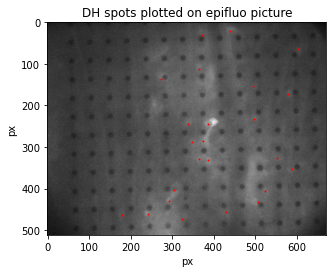

In [46]:
# Plot the DH spots on top of 40X epifluorescence image
fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(epifluorescence_40x_picture, cmap='gray')
for i in point_coordinates_40X_px:
    ax.scatter(i[0], i[1], color='r', marker='o', s=1)
    
ax.set_title("DH spots plotted on epifluo picture")
ax.set_xlabel("px")
ax.set_ylabel("px")

plt.savefig(os.path.join(sanity_check_directory, "DH_spots_epi_picture"))

### TODO: double check that the rotation of the checkerboard is correct


# SECTION 2: transform DH spot coordinates, RF centers and ellipses to the MEA referential

# Convert DH spots coordinates in MEA referential

In [50]:
# Transform DH spots in MEA referential

h_camera_40X_to_mea = np.load(os.path.join(homographies_directory,"h_camera_40X_to_mea.npy"))
h_epifluo_to_40X = np.load(os.path.join(homographies_directory,"h_epifluo_to_40X.npy"))

t_dh = point_coordinates_40X_px 

t_dh = []

for coordinates in point_coordinates_40X_px:
    t_dh += [[i for i in transform_coordinates(coordinates, h_camera_40X_to_mea@h_epifluo_to_40X)]]
    
dh_in_mea_referential = np.save(os.path.join(params.output_directory,f"{params.exp}_dh_coordinates_in_mea_referential"),t_dh) 

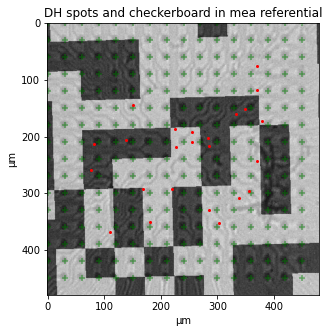

In [51]:
# SANITY CHECK: Overlay DH spots on the rest
h_camera_10X_to_mea = np.load(os.path.join(homographies_directory,"h_camera_10X_to_mea.npy"))
h_checkerboard_to_dmd = np.load(os.path.join(homographies_directory,"h_checkerboard_to_dmd.npy"))
h_dmd_to_camera_10X = np.load(os.path.join(homographies_directory,"h_dmd_to_camera_10X.npy"))


dh_coordinates_in_mea_referential = np.load(os.path.join(params.output_directory,f"{params.exp}_dh_coordinates_in_mea_referential.npy"))

# Sanity check. Plot the checkerboard and the picture in the camera 10X referential, with the electrodes ploted
checkerboard_frame = np.random.choice([0,1], size=(number_of_check[0],number_of_check[1])).astype(np.uint8)

t_checker = cv2.warpPerspective(checkerboard_frame, h_camera_10X_to_mea@h_dmd_to_camera_10X@h_checkerboard_to_dmd, (16*30,16*30), flags=cv2.INTER_NEAREST)
t_picture = cv2.warpPerspective(mea_10x_picture, h_camera_10X_to_mea, (16*30,16*30), flags=cv2.INTER_NEAREST)


fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(t_picture, cmap='gray')

ax.imshow(t_checker, cmap='gray', alpha=.5)
for j in range(16):
    for i in range(16):
        coordinates = [i*30,j*30]
        ax.scatter(coordinates[0],coordinates[1], marker='+', color='g', alpha=.5)

for coordinates in dh_coordinates_in_mea_referential:
    ax.scatter(coordinates[0],coordinates[1], marker='o', color='r', alpha=1, s=4)

ax.set_title("DH spots and checkerboard in mea referential")
ax.set_xlabel("µm")
ax.set_ylabel("µm")
    
plt.savefig(os.path.join(sanity_check_directory, "DH_spots_and_checkerboard_in_mea_referential"))

# Convert STA coordinates and ellipses in MEA referential


In [54]:
def get_ellipse(parameters,factor=2):
        
    amplitude, x0, y0, sigma_x, sigma_y, theta = parameters
    width = factor * 2.0 * sigma_x
    height = factor * 2.0 * sigma_y

    t = np.linspace(0, 2*np.pi, 360)
    
    Ell = np.array([sigma_x*np.cos(t) , sigma_y*np.sin(t)])
    
    R_rot = np.array([[np.cos(-np.deg2rad(theta)) , -np.sin(-np.deg2rad(theta))]
                      ,[np.sin(-np.deg2rad(theta)) , np.cos(-np.deg2rad(theta))]])  
    
    Ell = np.dot(R_rot, Ell)
    Ell[0,:] += x0
    Ell[1,:] += y0
    ell_size = np.abs(np.pi*width*height)
    ell_meas = 1-min(width, height)/max(width, height)
    
    return Ell, ell_size, ell_meas

In [55]:
# Load STAs

stas = load_obj(os.path.join(params.output_directory,"sta_data_3D_fitted.pkl"))

h_camera_10X_to_mea = np.load(os.path.join(homographies_directory,"h_camera_10X_to_mea.npy"))
h_checkerboard_to_dmd = np.load(os.path.join(homographies_directory,"h_checkerboard_to_dmd.npy"))
h_dmd_to_camera_10X = np.load(os.path.join(homographies_directory,"h_dmd_to_camera_10X.npy"))

# transform center coordinates

rf_coordinates_in_mea_referential = {}
ellipse_in_mea_referential = {}

for cell in stas.keys():
    
    center_coordinates = stas[cell]['center_analyse']['EllipseCoor'][1:3]
        
    t_coordinates = [i for i in transform_coordinates(center_coordinates, h_camera_10X_to_mea@h_dmd_to_camera_10X@h_checkerboard_to_dmd)]
    
    rf_coordinates_in_mea_referential[cell] = t_coordinates
    
save_obj(rf_coordinates_in_mea_referential, os.path.join(params.output_directory,f"{params.exp}_rf_coordinates_in_mea_referential")) 

# generate ellipse and transform curve points

for cell in stas.keys():
    
    ellipse,_,_ = get_ellipse(stas[cell]['center_analyse']['EllipseCoor'])
            
    t_coordinates = np.zeros((2,360))
    for i in range(360):

        t_coordinates[:,i] = [i for i in transform_coordinates(ellipse[:,i], h_camera_10X_to_mea@h_dmd_to_camera_10X@h_checkerboard_to_dmd)]
    
    ellipse_in_mea_referential[cell] = t_coordinates
    
save_obj(ellipse_in_mea_referential, os.path.join(params.output_directory,f"{params.exp}_ellipse_in_mea_referential")) 


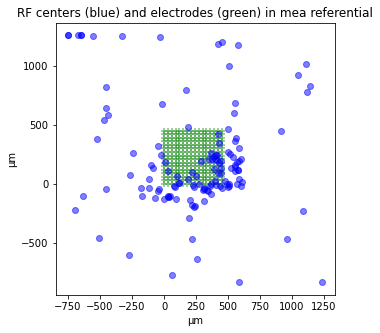

In [57]:
# Sanity check

rf_coordinates_in_mea_referential = load_obj(os.path.join(params.output_directory,f"{params.exp}_rf_coordinates_in_mea_referential"))

fig, ax = plt.subplots(figsize=(5,5))

for j in range(16):
    for i in range(16):
        coordinates = [i*30,j*30]
        ax.scatter(coordinates[0],coordinates[1], marker='+', color='g', alpha=.5)
        
for cell in stas.keys():
    rf_coordinates = rf_coordinates_in_mea_referential[cell]
    
    plt.scatter(rf_coordinates[0],rf_coordinates[1], marker='o', color='b', alpha=.5)
    
ax.set_title("RF centers (blue) and electrodes (green) in mea referential")
ax.set_xlabel("µm")
ax.set_ylabel("µm")

plt.savefig(os.path.join(sanity_check_directory, "rf_center_registration"))

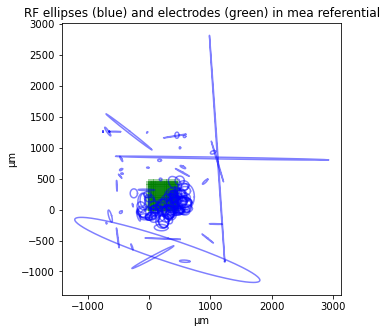

In [59]:
# Sanity check

ellipse_in_mea_referential = load_obj(os.path.join(params.output_directory,f"{params.exp}_ellipse_in_mea_referential"))

fig, ax = plt.subplots(figsize=(5,5))

for j in range(16):
    for i in range(16):
        coordinates = [i*30,j*30]
        ax.scatter(coordinates[0],coordinates[1], marker='+', color='g', alpha=.5)
        
for cell in stas.keys():
    ellipse = ellipse_in_mea_referential[cell]
    
    ax.plot(ellipse[0,:],ellipse[1,:], color='b', alpha=.5)

ax.set_title("RF ellipses (blue) and electrodes (green) in mea referential")
ax.set_xlabel("µm")
ax.set_ylabel("µm")

plt.savefig(os.path.join(sanity_check_directory, "rf_ellipses_registration"))

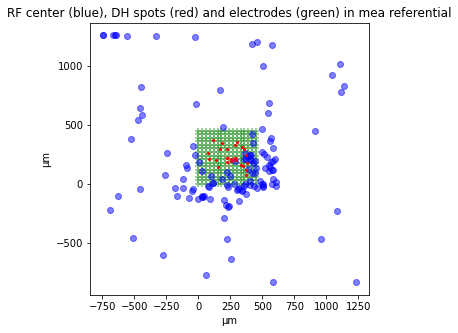

In [61]:
# Sanity check

rf_coordinates_in_mea_referential = load_obj(os.path.join(params.output_directory,f"{params.exp}_rf_coordinates_in_mea_referential"))
dh_coordinates_in_mea_referential = np.load(os.path.join(params.output_directory,f"{params.exp}_dh_coordinates_in_mea_referential.npy"))

fig, ax = plt.subplots(figsize=(5,5))

for j in range(16):
    for i in range(16):
        coordinates = [i*30,j*30]
        ax.scatter(coordinates[0],coordinates[1], marker='+', color='g', alpha=.5)
        
for cell in stas.keys():
    rf_coordinates = rf_coordinates_in_mea_referential[cell]
    
    ax.scatter(rf_coordinates[0],rf_coordinates[1], marker='o', color='b', alpha=.5)
    
for coordinates in dh_coordinates_in_mea_referential:
    ax.scatter(coordinates[0],coordinates[1], marker='o', color='r', alpha=1, s=4) 
    
    
ax.set_title("RF center (blue), DH spots (red) and electrodes (green) in mea referential")
ax.set_xlabel("µm")
ax.set_ylabel("µm")

plt.savefig(os.path.join(sanity_check_directory, "rf_center_dh_spot_registration"))

# Compute the distance between dh spot and rf center for each pair

In [62]:
def find_angle(a,b,c):
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    
    return np.degrees(angle)

def find_aligned_point(point, ellipse, sanity_check=True):
    ellipse_center = np.mean(ellipse, axis=1)
    index = 0

    angle = 10000
    
    for i in range(360):
        angle_temp = find_angle(point,ellipse_center, ellipse[:,i])
        if angle_temp < angle:
            angle = angle_temp
            index = i
            
    closest_point = ellipse[:,index]
            
    if sanity_check:
            
        plt.figure()
        plt.plot(ellipse[1],ellipse[0])
        plt.scatter(ellipse_center[1],ellipse_center[0], marker='+')
        plt.scatter(closest_point[1],closest_point[0], color="green")
        plt.scatter(point[1],point[0], color='r')
        
            
    return closest_point


def compute_distance_between_points(point_1, point_2):
    distance = np.linalg.norm(point_1 - point_2)
    return distance

In [63]:
rf_coordinates_in_mea_referential = load_obj(os.path.join(params.output_directory,f"{params.exp}_rf_coordinates_in_mea_referential"))
dh_coordinates_in_mea_referential = np.load(os.path.join(params.output_directory,f"{params.exp}_dh_coordinates_in_mea_referential.npy"))
ellipse_in_mea_referential = load_obj(os.path.join(params.output_directory,f"{params.exp}_ellipse_in_mea_referential"))


registration_distances = {}

for cell_nb in tqdm(stas.keys()):
    
    if not cell_nb in registration_distances.keys(): registration_distances[cell_nb]={}
    
    rf_center = rf_coordinates_in_mea_referential[cell_nb]
    ellipse = ellipse_in_mea_referential[cell_nb]
    
    
    for i_spot in range(dh_coordinates_in_mea_referential.shape[0]):
        
        #in these coordinates the axis don't start from zero
        spot_coord = dh_coordinates_in_mea_referential[i_spot]
        
        #distance between the spot and the RF center
        distance = compute_distance_between_points(rf_center,spot_coord)
        
        closest_point = find_aligned_point(spot_coord, ellipse, sanity_check=False)
        radius = compute_distance_between_points(rf_center, closest_point)
        
        #ditance between spot and RF in terms of nb of RF width
        relative_distance = distance / radius
        
        registration_distances[cell_nb][i_spot]={'absolute_distance': distance, 'relative_distance': relative_distance }

save_obj(registration_distances, os.path.join(params.output_directory,f"{params.exp}_registration_distances")) 


  0%|          | 0/131 [00:00<?, ?it/s]

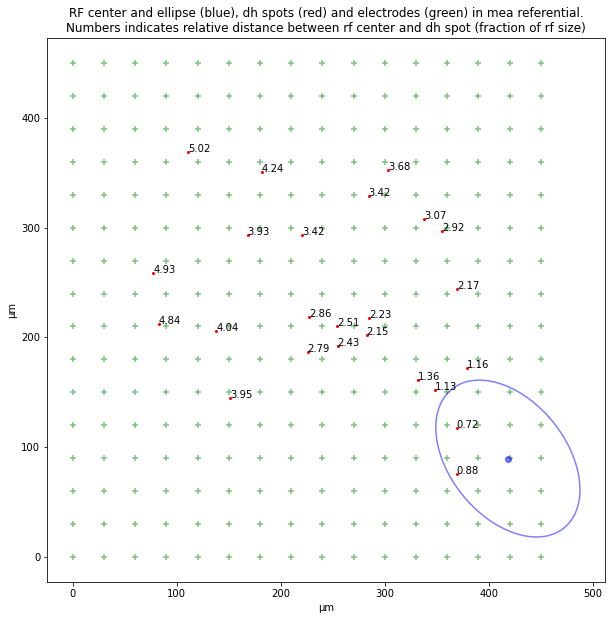

In [69]:
# Sanity checks


cell = 17 # Here you should pick a good cell

stas = load_obj(os.path.join(params.output_directory,"sta_data_3D_fitted.pkl"))
rf_coordinates_in_mea_referential = load_obj(os.path.join(params.output_directory,f"{params.exp}_rf_coordinates_in_mea_referential"))
dh_coordinates_in_mea_referential = np.load(os.path.join(params.output_directory,f"{params.exp}_dh_coordinates_in_mea_referential.npy"))
ellipse_in_mea_referential = load_obj(os.path.join(params.output_directory,f"{params.exp}_ellipse_in_mea_referential"))
registration_distances = load_obj(os.path.join(params.output_directory,f"{params.exp}_registration_distances"))


fig, ax = plt.subplots(figsize=(10,10))

for j in range(16):
    for i in range(16):
        coordinates = [i*30,j*30]
        ax.scatter(coordinates[0],coordinates[1], marker='+', color='g', alpha=.5)
        
rf_coordinates = rf_coordinates_in_mea_referential[cell]
ax.scatter(rf_coordinates[0],rf_coordinates[1], marker='o', color='b', alpha=.5)    


ellipse = ellipse_in_mea_referential[cell]
ax.plot(ellipse[0,:],ellipse[1,:], color='b', alpha=.5)

for i_spot in range(dh_coordinates_in_mea_referential.shape[0]):
    
    coordinates = dh_coordinates_in_mea_referential[i_spot,:]
    
    ax.scatter(coordinates[0],coordinates[1], marker='o', color='r', alpha=1, s=4)
    
    ax.annotate(round((registration_distances[cell][i_spot]['relative_distance']),2),(coordinates[0],coordinates[1]))
    
ax.set_title("RF center and ellipse (blue), dh spots (red) and electrodes (green) in mea referential.\nNumbers indicates relative distance between rf center and dh spot (fraction of rf size)")
ax.set_xlabel("µm")
ax.set_ylabel("µm")

plt.savefig(os.path.join(sanity_check_directory, "relative_distance_computation"))  

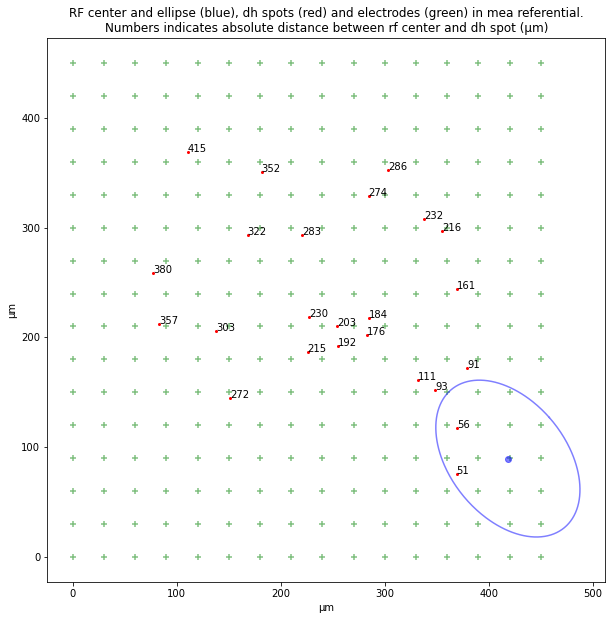

In [71]:
# Sanity checks


cell = 17 # Here you should pick a good cell


stas = load_obj(os.path.join(params.output_directory,"sta_data_3D_fitted.pkl"))
rf_coordinates_in_mea_referential = load_obj(os.path.join(params.output_directory,f"{params.exp}_rf_coordinates_in_mea_referential"))
dh_coordinates_in_mea_referential = np.load(os.path.join(params.output_directory,f"{params.exp}_dh_coordinates_in_mea_referential.npy"))
ellipse_in_mea_referential = load_obj(os.path.join(params.output_directory,f"{params.exp}_ellipse_in_mea_referential"))
registration_distances = load_obj(os.path.join(params.output_directory,f"{params.exp}_registration_distances"))


fig, ax = plt.subplots(figsize=(10,10))

for j in range(16):
    for i in range(16):
        coordinates = [i*30,j*30]
        ax.scatter(coordinates[0],coordinates[1], marker='+', color='g', alpha=.5)
        
rf_coordinates = rf_coordinates_in_mea_referential[cell]
ax.scatter(rf_coordinates[0],rf_coordinates[1], marker='o', color='b', alpha=.5)    


ellipse = ellipse_in_mea_referential[cell]
ax.plot(ellipse[0,:],ellipse[1,:], color='b', alpha=.5)

for i_spot in range(dh_coordinates_in_mea_referential.shape[0]):
    
    coordinates = dh_coordinates_in_mea_referential[i_spot,:]
    
    ax.scatter(coordinates[0],coordinates[1], marker='o', color='r', alpha=1, s=4)
    
    ax.annotate(int(registration_distances[cell][i_spot]['absolute_distance']),(coordinates[0],coordinates[1]))
    
ax.set_title("RF center and ellipse (blue), dh spots (red) and electrodes (green) in mea referential.\nNumbers indicates absolute distance between rf center and dh spot (µm)")
ax.set_xlabel("µm")
ax.set_ylabel("µm")

plt.savefig(os.path.join(sanity_check_directory, "absolute_distance_computation")) 